In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

In [9]:
test1_df = pd.read_csv('SE_rents2018_test1.csv', index_col=0)
test2_df = pd.read_csv('SE_rents2018_test2.csv', index_col=0)
test3_df = pd.read_csv('SE_rents2018_test3.csv', index_col=0)

train_df = pd.read_csv('SE_rents2018_train.csv', index_col=0)


# bedrooms, bathrooms, size_sqft, and year_built use for linear model.
# borough, neighborhood, has_doorman, and size_sqft for non-linear model. 

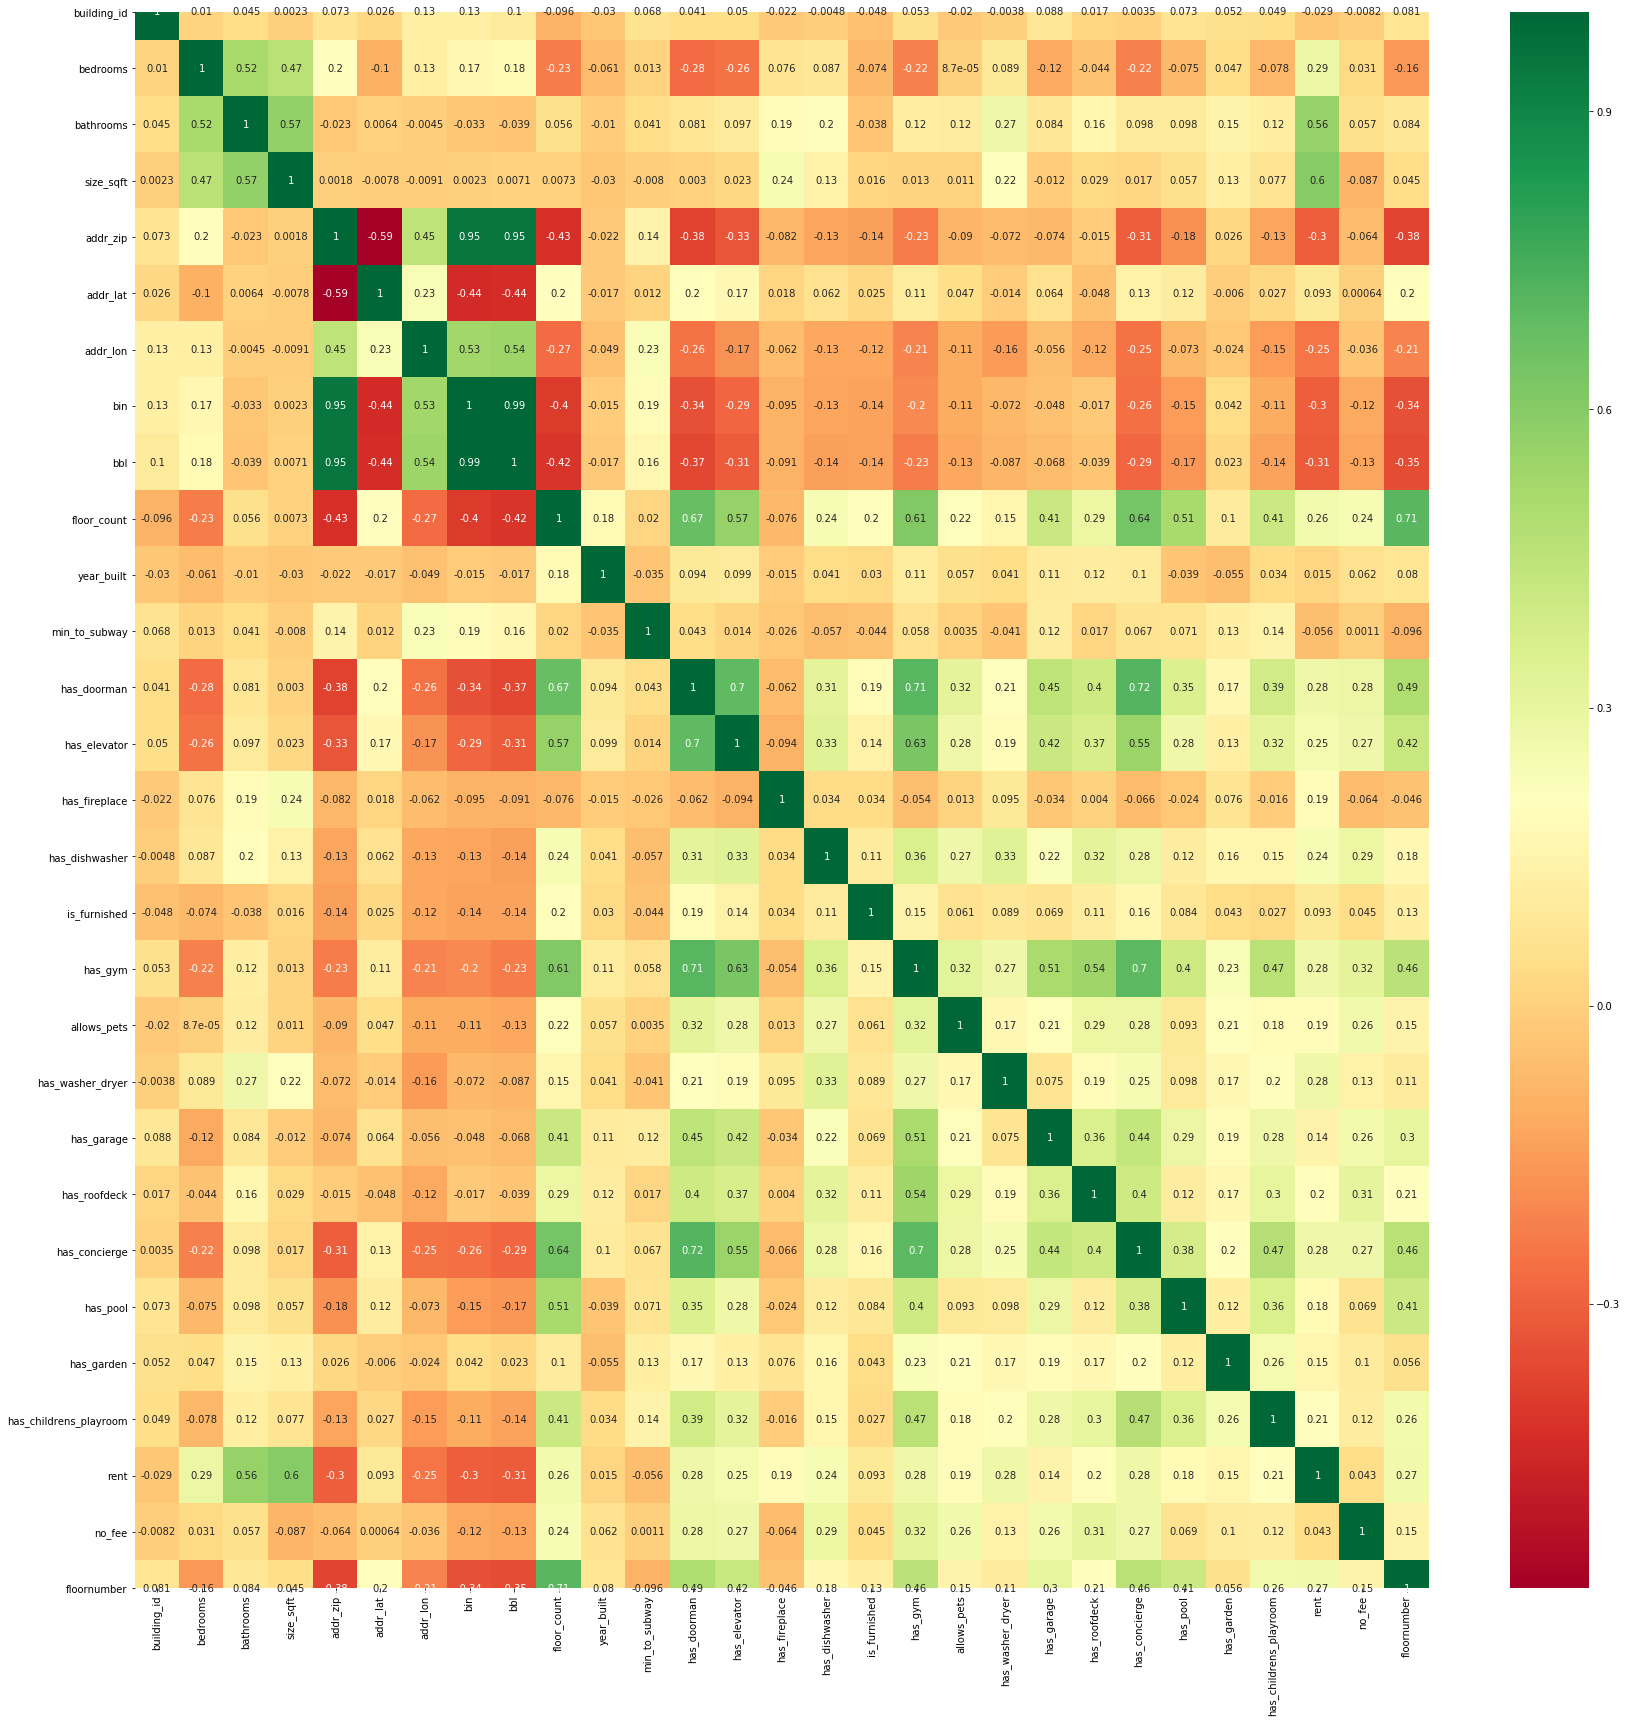

In [23]:
#using a heatmap to select meaningful features
#columns = test1_df[:,0:29]
#target = test1_df.rent
corrmat = test1_df.corr()
test1_top_corr = corrmat.index
plt.figure(figsize=(29,29))
test1_g = sns.heatmap(test1_df[test1_top_corr].corr(), annot=True, cmap="RdYlGn")

In [20]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None,
    resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
    np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl,
                    edgecolor='black')
        
    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c='', edgecolor='black', alpha=1.0,
                    linewidth=1, marker='o',
                    s=100, label='test set')



from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def train_linear_reg_model(X_train, y_train, X_test, y_test):
    """Trains and test linear regression model and returns mean_squared_error of
    y_test and y_predicted. 
    ----------
    X_train : array-like, shape = [n_samples, n_features]
        n_samples the number of samples
        n_features the number of features for each sample.
        
    y_train : array-like, shape = [n_samples]
        n_sample target values.
        
    X_test : array-like, shape = [n_samples, n_features]
        n_samples the number of samples
        n_features the number of features for each sample.
        
    y_test : array-like, shape = [n_samples]
        n_sample target values.
        
    Return 
        (float) mean_squared_error of (y_test and y_prediction)

    
    """

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    

    
    y_prediction = lr.predict(X_test)
    
    return mean_squared_error(y_test, y_prediction)

In [5]:
columns_needed = ['bedrooms', 'bathrooms', 'size_sqft', 'year_built','rent']
linear_reg_train_df = train_df[columns_needed]

# There are 11597 non-null entries in year_built out of 12000.
# I will drop these null entries. 
train_dropped_na_df = linear_reg_train_df.dropna(axis=0)
train_dropped_na_df.info()

# Convert dataframes to numpy array.
features = ['bedrooms', 'bathrooms', 'size_sqft', 'year_built']
train_dropped_na_arr = train_dropped_na_df[features]
train_dropped_na_target_arr = train_dropped_na_df[['rent']]

test1_lr_df = test1_df[['bedrooms', 'bathrooms', 'size_sqft', 'year_built','rent']].dropna(axis=0)
test1_lr_arr = test1_lr_df[features]
test1_lr_target_arr = test1_lr_df[['rent']]

train_linear_reg_model(train_dropped_na_arr, train_dropped_na_target_arr,test1_lr_arr,test1_lr_target_arr)



<class 'pandas.core.frame.DataFrame'>
Int64Index: 11597 entries, 7236931 to 7422694
Data columns (total 5 columns):
bedrooms      11597 non-null int64
bathrooms     11597 non-null float64
size_sqft     11597 non-null float64
year_built    11597 non-null float64
rent          11597 non-null int64
dtypes: float64(3), int64(2)
memory usage: 543.6 KB


4206183.777622638